# mfinder_python

This notebook is python wrapper of network motif analyzer mfinder1.2. It has codes for the following steps and link them as a pipleline to analyze motif (subgraph) from network.

- Read graph from dictionary of NetworkX graph objects(.pkl) or directory containg graph files (/.gexf)

- **Run mfinder1.2** on the graph data : this analyzes numbers in real/randomized network, z-score for each motif id

- Compute **signifcance profile(SP; normalized z-score)** based on mfinder1.2 result for each motif id

- Write result of step 2. and step 3. as csv(.csv) file

- Visualize significance profile of the network using pyplot

#### Reference

every resources of directory mfinder1.2 references following work of Milo R. et al.

https://www.weizmann.ac.il/mcb/UriAlon/download/network-motif-software

Milo R, Shen-Orr S, Itzkovitz S, Kashtan N, Chklovskii D, Alon U. Network motifs: simple building blocks of complex networks. Science. 2002 Oct 25;298(5594):824-7. doi: 10.1126/science.298.5594.824. PMID: 12399590.

#### Dependencies

In [118]:
import networkx as nx
import numpy as np
import os
import subprocess
import pandas as pd
import pickle

#### Choose dataset (dataset_name)

In [119]:
# data should be under data/'datset_name' directory.
# e.g. data/culturalDNA_2022/ (...data here...)
# directory 'dataset_name' should be under input/ and output/
# e.g. input/culturalDNA_2022, output/culturalDNA_2022

# dataset_name = 'hubs-research-acm-chi-2021'
dataset_name = 'culturalDNA_2022'

#### Pipeline
graph obejct > preprocess > mfinder1.2 > postprocess > dataframe (.csv)   

In [120]:
def mfinder_prepare_input(G, file_name, dataset_name):

    # Preprocess graph : remove nan or 0 weighted edges
    edge_weights = nx.get_edge_attributes(G,'weight')
    G.remove_edges_from((e for e, w in edge_weights.items() if np.isnan(w) or w == 0))

    # Convert graph to edge lists and export as .txt file 
    input_path = '../input/{}/{}.txt'.format(dataset_name, file_name)

    with open(input_path, 'w') as f:
        for u, v in G.edges(data=False):
            f.write((' ').join(map(str, [u, v, 1]))+'\n') # Edge weight is ignored (weight = 1) in mfinder. Refer to the manual for the input format.

    return input_path

def mfinder_run(input_path, file_name, dataset_name):

    output_path = '../output/{}/{}'.format(dataset_name, file_name)
    
    output_path = input_path.replace('input', 'output').rstrip('.txt')
    
    # Run mfinder1.2
    # @TODO Set your own argument options here.
    # Refer to the manual for the arguement options.
    # -f sets output path
    # -rdm relaxes the constraint of conserving of mutual edges in random network generation. The mutual edges are conserved in random network generation by default.   
    command = '../mfinder1.2/mfinder1.2.exe {} -f {} -rdm'.format(input_path, output_path)
    print(command)
    subprocess.run(command.split(' '))     

    return output_path + '_OUT.txt'

def mfinder_postprocess_output(output_path, file_name):

    additional_columns = ['additional_column']
    column_names = ['motif_id', 'nreal_stats', 'nrand', 'zscore', 'nreal_pval', 'creal', 'uniq']

    with open(output_path, 'r') as f:     
        lines = f.readlines()
        data_start_index = 0  
        for index, line in enumerate(lines):
            if 'Total num of different subgraphs size' in line:
                data_start_index = index
                break

        data_split = [line.strip().split() for line in lines[data_start_index + 4 : data_start_index + 28] if line.rstrip()] 

    df = pd.DataFrame(data_split, columns = column_names).apply(pd.to_numeric, errors='ignore')    
    denominator = np.sqrt(np.sum(np.square(df['zscore'].astype(float))))
    df['sp'] = np.divide(df['zscore'], denominator)   

    # @TODO Write name of index of the analysis results here.
    df['index'] = file_name

    # @TODO Build additional columns for result dataframe here. 
    df['additional_column'] = np.nan

    df = df.reindex(columns=['index', 'sp'] + column_names + additional_columns) 

    return df

#### Run mfinder starting from dictionary of NetworkX graph objects (.pkl)

In [121]:
### mfinder_from_graph_dictionary(graph_dictionary, dataset_name)
### [parameters]
### graph_dictionary : 
### dict {key1: graph1, key2 : graph2, ...}
### The keys are used as unique indexes of each graph in result dataframe and as file names for all intermediate and result files. 
### @TODO Prepare your own dictionary of graphs that are interested.
def mfinder_from_graph_dictionary(graph_dictionary, dataset_name):

    # @TODO Format title of the .csv file to save the analysis results.
    title = 'title'

    column_names_additional = ['additional_column']
    column_names = ['index', 'sp', 'motif_id', 'nreal_stats', 'nrand', 'zscore', 'nreal_pval', 'creal', 'uniq']

    # @TODO Write name of index of the analysis results here.
    motif_analysis_df = pd.DataFrame(columns = column_names + column_names_additional)    

    for key in graph_dictionary:   

        G = graph_dictionary[key]
        file_name = key # dictionary key is used as a file name for intermediate and result files for analysis of this graph

        # Pipeline
        input_path = mfinder_prepare_input(G, file_name, dataset_name)
        output_path = mfinder_run(input_path, file_name, dataset_name)
        df = mfinder_postprocess_output(output_path, file_name)
        motif_analysis_df = pd.concat([motif_analysis_df, df])

    # print(motif_analysis_df)
    motif_analysis_df.to_csv('../output/{}/{}.csv'.format(dataset_name, title), index=False)
            
    return motif_analysis_df

In [122]:
# The example dictionary is doubly nested dictionary.
# mfinder_from_graph_dictionary takes simple dictionary as input so we build single dictionary using key = 3.6 (m) for the outer dictionary 
# Example graph dictionary structure
graph1, graph2, graph3, graph4 = nx.graph, nx.graph, nx.graph, nx.graph

dictionary_structure = {3.6 : {'d1break' : graph1, 'd2break' : graph2}, 7.2 : {'d1break' : graph3, 'd2break' : graph4}}

# Read
with open("../data/{}/graphs_by_max_distance_session_name.pkl".format(dataset_name), "rb") as f:
    graphs_by_max_distance_session_name = pickle.load(f)

key = 3.6
graph_dictionary_by_session_name = graphs_by_max_distance_session_name[key]
motif_analysis_df = mfinder_from_graph_dictionary(graph_dictionary_by_session_name, dataset_name)

../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d1intro.txt -f ../output/culturalDNA_2022/d1intro -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d1lec1.txt -f ../output/culturalDNA_2022/d1lec1 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d1lec2.txt -f ../output/culturalDNA_2022/d1lec2 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d1lec3.txt -f ../output/culturalDNA_2022/d1lec3 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d1break.txt -f ../output/culturalDNA_2022/d1break -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d1lec4.txt -f ../output/culturalDNA_2022/d1lec4 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d1lec5.txt -f ../output/culturalDNA_2022/d1lec5 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d2lec1.txt -f ../output/culturalDNA_2022/d2lec1 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/d2lec2.txt -f ../output/culturalDNA_2022/d2lec2 -rdm
../mfinder1.2/mfinder1.2

#### Run mfinder starting from the directory with graph files (/~.gexf)

In [123]:
### mfinder_from_graph_dictionary(graph_dictionary, dataset_name)
### [parameters]
### graph_dictionary : 
### dict {key1: graph1, key2 : graph2, ...}
### The keys are used as unique indexes of each graph in result dataframe and as file names for all intermediate and result files. 
### @TODO Prepare your own dictionary of graphs that are interested.
def mfinder_from_gexf_directory(directory, dataset_name):

    # @TODO Format title of the .csv file to save the analysis results.
    title = 'title'

    column_names_additional = ['additional_column']
    column_names = ['index', 'sp', 'motif_id', 'nreal_stats', 'nrand', 'zscore', 'nreal_pval', 'creal', 'uniq']

    # @TODO Write name of index of the analysis results here.
    motif_analysis_df = pd.DataFrame(columns = column_names + column_names_additional)    

    for file_name in os.listdir(directory): # file name is used as a file name for intermediate and result files for analysis of this graph
        if ('.gexf' not in file_name):
            continue

        f = os.path.join(directory, file_name)
        if os.path.isfile(f):
            
            file_name = file_name.strip('.gexf')

            # Read graph from .gexf
            G = nx.read_gexf(f)

            # Pipeline
            input_path = mfinder_prepare_input(G, file_name, dataset_name)
            output_path = mfinder_run(input_path, file_name, dataset_name)
            df = mfinder_postprocess_output(output_path, file_name)
            motif_analysis_df = pd.concat([motif_analysis_df, df])

    motif_analysis_df.to_csv('../output/{}/{}.csv'.format(dataset_name, title))
            
    return motif_analysis_df

In [124]:
directory = '../data/{}/gexf'.format(dataset_name)

motif_analysis_df = mfinder_from_gexf_directory(directory, dataset_name)

../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d1break.txt -f ../output/culturalDNA_2022/3.6_d1break -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d1intro.txt -f ../output/culturalDNA_2022/3.6_d1intro -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d1lec1.txt -f ../output/culturalDNA_2022/3.6_d1lec1 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d1lec2.txt -f ../output/culturalDNA_2022/3.6_d1lec2 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d1lec3.txt -f ../output/culturalDNA_2022/3.6_d1lec3 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d1lec4.txt -f ../output/culturalDNA_2022/3.6_d1lec4 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d1lec5.txt -f ../output/culturalDNA_2022/3.6_d1lec5 -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d2break.txt -f ../output/culturalDNA_2022/3.6_d2break -rdm
../mfinder1.2/mfinder1.2.exe ../input/culturalDNA_2022/3.6_d2closi

#### Visualize Motif significance profile

In [139]:
import matplotlib.pyplot as plt

### visualize_motif_sp(motif_analysis_df)
### [parameters]
### motif_analysis_df : 
### pd.Dataframe(index = [index], columns = [])
### @TODO parameter should be a dataframe with the noted columns, one analysis result per each row indexed. All analysis results are visualized as multiple lines in one chart.   
### Indexes should be unique (only one row per index)
def visualize_motif_sp(motif_analysis_df, dataset_name):
    
    title = 'title' # title to write on the visualization

    save_title = 'title' # title of the .jpg file

    plt.figure()
    plt.title(title)
    plt.xlabel('motif_id') # x label
    plt.ylabel('significance profile') # y label
    plt.axhline(y=0, c='black') # horizontal line y = 0

    # @TODO Chanee plot markers here
    markers = ["o","v","^","<",">","8","s","p","P","*","h","H","X","D","d"] 
    markers_dict = dict(zip(motif_analysis_df['index'].unique(), markers[:len(motif_analysis_df['index'].unique())]))
    print(markers_dict)
    for index, row in motif_analysis_df.groupby('index'):

        # @TODO Set colors of each index here
        # In this example, index of [parameter]motif_analysis_df is session name (e.g. d1lec1, d1break, ...)
        # and data is colored based on the type (social / lecture) of the session
        if (dataset_name == 'culturalDNA_2022'):
            color = '#035efc' if 'lec' in index or 'intro' in index else '#fc8403'
        elif (dataset_name == 'hubs-research-acm-chi-2021'):
            color = '#035efc' if 'break' not in index else '#fc8403' 
        
        plt.plot(row.motif_id.astype(str), row.sp, marker= markers_dict[index], color = color, label = index, alpha=0.3) # plots a line

    lgd = plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5)) # set location of legend info.

    plt.savefig('../output/{}/{}.jpg'.format(dataset_name, save_title), # save as .jpg file
        bbox_extra_artists=(lgd,),
        bbox_inches='tight',
        format ='jpg',
        dpi=1200)

{'3.6_d1break': 'o', '3.6_d1intro': 'v', '3.6_d1lec1': '^', '3.6_d1lec2': '<', '3.6_d1lec3': '>', '3.6_d1lec4': '8', '3.6_d1lec5': 's', '3.6_d2break': 'p', '3.6_d2closin': 'P', '3.6_d2lec1': '*', '3.6_d2lec2': 'h', '3.6_d2lec3': 'H', '3.6_d2lec4': 'X'}


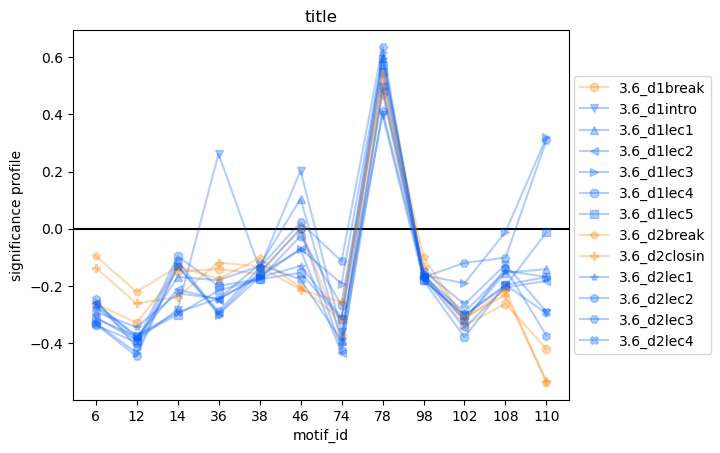

In [140]:
visualize_motif_sp(motif_analysis_df, dataset_name)